### Introduction  

On an average a Data centers there are tens of thousands of Network devices, fibers, cables and patch etc. Each Network device for example Router or a Switch are basically mode up of various parts like slots shelfs for different types of cards and connection modules and for robust networks network augmentation, migration and decom is integral part of operation but imagine the amount of manual work need to be done for maintaining such a huge network inventory. 

Usually, the inventory is updated into a digital tools. Although digital tools are advantageous when it comes to updating and tracking the changes performed and managing inventory still the device details had to be manually added to the tools each and every time a change is made which increase the chance of manual errors, my vision is to design a tool that can update the change inventory by just scanning the images of device. Where the model will detect and recognize the text from the images  using deep learning framework. 

However Text detection and recognition task has seen hug attention in  computer vison community still extracting text data from real-world images is considered a one of the challenging task due to the complexity of the natural images. 
 

### DL formulation - of business problem 

We have three task to perform mainly text detection from image, text recognition and finally text translation and for performing all the tasks using Deep Learning models. 

Text detection: where the model localizing text by drawing bounding boxes around the text. 

Text Recognizing: After text detection comes text recognition where the detected textual regions are further processed in order to recognize what is the text in English. 

 

### Business constraints  

Images of the Data center network devices many have security implications, so will be training the model with ICDAR 2015 Dataset 

As natural images can be blurred, noisy, and in low quality with complex background. This makes difficult to detect textual regions. 

Low latency is needed as the model is need to detect and recognize the text in the images in real time. 

In [1]:
!pip install tf_slim
!pip install pytesseract
!sudo apt install tesseract-ocr

     |████████████████████████████████| 358kB 4.1MB/s 
  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=21a583430315e3595eca11460e9e0d60dd740934e3f342363e33cc7a58f4da4a
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/unive

In [2]:
import numpy as np
import cv2
import os
import math
import random
import tensorflow as tf
import re

import tf_slim as slim

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, concatenate, BatchNormalization, Lambda, Input, multiply, add, ZeroPadding2D, Activation, Layer, MaxPooling2D, Dropout
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

from PIL import Image, ImageDraw
import os
import random
from tqdm import tqdm

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from google.colab.patches import cv2_imshow
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt

import re
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import time
import pytesseract
from imutils.object_detection import non_max_suppression
import time
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/case_2_ICDAR_2015/icdar2015.zip

Archive:  /content/drive/MyDrive/case_2_ICDAR_2015/icdar2015.zip
  inflating: Challenge4_Test_Task1_GT/gt_img_1.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_10.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_100.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_101.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_102.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_103.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_104.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_105.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_106.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_107.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_108.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_109.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_11.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_110.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_111.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_112.txt  
  inflating: Challenge4_Test_Task1_GT/gt_img_113.txt  
  in

## Preprocessing

In [5]:
train_path_image="training_images"
train_path_mask="training_gt"

In [6]:
test_path_image="test_images"
test_path_mask="test_gt"

In [7]:
def get_path (path):
    file_path=[]

    for i in os.listdir(path):
        new_path=path+"/"+i
        #for j in os.listdir(new_path):
        file_path.append(new_path)
    return file_path 

In [8]:
def return_file_names_df(path_image,path_mask):
    
    image=get_path(path_image)
    mask=get_path(path_mask)
    data_df=pd.DataFrame(image,columns=['image'])
    data_df['GT_Path']=mask
    return data_df

In [9]:
train_data_df=pd.read_csv('/content/preprocessed_train.csv')
test_data_df=pd.read_csv('/content/preprocessed_test.csv')

In [10]:

train_data_df.head(5)

,image,GT_Path
0,training_images/img_1.jpg,training_gt/gt_img_1.txt
1,training_images/img_10.jpg,training_gt/gt_img_10.txt
2,training_images/img_100.jpg,training_gt/gt_img_100.txt
3,training_images/img_1000.jpg,training_gt/gt_img_1000.txt
4,training_images/img_101.jpg,training_gt/gt_img_101.txt


In [11]:

test_data_df.head(5)

,image,GT_Path
0,test_images/img_1.jpg,test_gt/gt_img_1.txt
1,test_images/img_10.jpg,test_gt/gt_img_10.txt
2,test_images/img_100.jpg,test_gt/gt_img_100.txt
3,test_images/img_101.jpg,test_gt/gt_img_101.txt
4,test_images/img_102.jpg,test_gt/gt_img_102.txt


In [12]:
train_data_df.shape,test_data_df.shape

((1000, 2), (500, 2))

In [13]:
def data_retrival(path):
    data = []
    f = open(path, "r",encoding='utf-8-sig')
    for x in f:
        data.append(x.split(','))
    return data

In [14]:
def ground_truth(path):
    final_cordinate = []
    final_GT = []
    for j in path:
        cordinate = []
        GT = []
        data = data_retrival(j)
        for i in data: ## Taking all the coordinates of text region in that image and appending that in a list boxes
            if i[8]!= '###\n':
                x1 = int(i[0])
                y1 = int(i[1])
                x2 = int(i[2])
                y2 = int(i[3])
                x3 = int(i[4])
                y3 = int(i[5])
                x4 = int(i[6])
                y4 = int(i[7])
                GT.append(i[8].replace("\n",""))
                vertex = [x1,y1,x2,y2,x3,y3,x4,y4]
                cordinate.append(vertex)
        final_GT.append(GT)
        final_cordinate.append(cordinate)
    return  final_cordinate,final_GT       

In [16]:


train_cordinate,train_GT=ground_truth(train_data_df['GT_Path'])
test_cordinate,test_GT=ground_truth(test_data_df['GT_Path'])

In [17]:
train_data_df['cordinate']=train_cordinate
train_data_df['GT']=train_GT
test_data_df['cordinate']=test_cordinate
test_data_df['GT']=test_GT

In [18]:
train_data_df.head(5)

,image,GT_Path,cordinate,GT
0,training_images/img_1.jpg,training_gt/gt_img_1.txt,"[[377, 117, 463, 117, 465, 130, 378, 130], [49...","[Genaxis Theatre, [06], 62-03, Carpark]"
1,training_images/img_10.jpg,training_gt/gt_img_10.txt,"[[288, 138, 417, 140, 416, 161, 290, 157], [74...","[HarbourFront, CC22, bua]"
2,training_images/img_100.jpg,training_gt/gt_img_100.txt,"[[645, 19, 686, 13, 692, 43, 651, 48], [689, 1...","[Way, out, Line, Platform]"
3,training_images/img_1000.jpg,training_gt/gt_img_1000.txt,[],[]
4,training_images/img_101.jpg,training_gt/gt_img_101.txt,"[[899, 214, 928, 213, 928, 241, 900, 242], [93...","[CARE, STICKER, FOR, MORE]"


In [19]:
train_data_df.shape,test_data_df.shape

((1000, 4), (500, 4))

In [20]:
train_index=[]
for j,i in enumerate(train_data_df['cordinate'].values):
    if len(i)==0:
        train_index.append(j)
        

In [21]:
test_index=[]
for j,i in enumerate(test_data_df['cordinate'].values):
    if len(i)==0:
        test_index.append(j)
        

In [22]:

train_data_df.drop(train_index,inplace=True)
test_data_df.drop(test_index,inplace=True)

In [23]:
train_data_df.head(5)

,image,GT_Path,cordinate,GT
0,training_images/img_1.jpg,training_gt/gt_img_1.txt,"[[377, 117, 463, 117, 465, 130, 378, 130], [49...","[Genaxis Theatre, [06], 62-03, Carpark]"
1,training_images/img_10.jpg,training_gt/gt_img_10.txt,"[[288, 138, 417, 140, 416, 161, 290, 157], [74...","[HarbourFront, CC22, bua]"
2,training_images/img_100.jpg,training_gt/gt_img_100.txt,"[[645, 19, 686, 13, 692, 43, 651, 48], [689, 1...","[Way, out, Line, Platform]"
4,training_images/img_101.jpg,training_gt/gt_img_101.txt,"[[899, 214, 928, 213, 928, 241, 900, 242], [93...","[CARE, STICKER, FOR, MORE]"
5,training_images/img_102.jpg,training_gt/gt_img_102.txt,"[[310, 504, 524, 426, 555, 517, 340, 594], [59...","[Shop, Dine, SMRT]"


In [24]:
train_data_df.shape,test_data_df.shape

((979, 4), (496, 4))

In [ ]:
#train_data_df.to_csv("preprocessed_train.csv",index=False)
#test_data_df.to_csv("preprocessed_test.csv",index=False)

### Text recognition: Pyteserract

In [27]:
split_rate = 0.1
data_dir = 'Final'
IMG_SIZE = 512
SRK_RATE = 0.1
input_size= 512

In [28]:
model = tf.keras.models.load_model('/content/drive/MyDrive/case_2_ICDAR_2015/My_EAST_Model.h5',compile=False)

In [258]:
def reorder_pts(xy_list, epsilon=1e-4):
    reorder_xy_list = np.zeros_like(xy_list)
    # determine the first point with the smallest x,
    # if two has same x, choose that with smallest y,
    ordered = np.argsort(xy_list, axis=0)
    xmin1_index = ordered[0, 0]
    xmin2_index = ordered[1, 0]
    if xy_list[xmin1_index, 0] == xy_list[xmin2_index, 0]:
        if xy_list[xmin1_index, 1] <= xy_list[xmin2_index, 1]:
            reorder_xy_list[0] = xy_list[xmin1_index]
            first_v = xmin1_index
        else:
            reorder_xy_list[0] = xy_list[xmin2_index]
            first_v = xmin2_index
    else:
        reorder_xy_list[0] = xy_list[xmin1_index]
        first_v = xmin1_index
    # connect the first point to others, the third point on the other side of
    # the line with the middle slope
    others = list(range(4))
    others.remove(first_v)
    k = np.zeros((len(others),))
    for index, i in zip(others, range(len(others))):
        k[i] = (xy_list[index, 1] - xy_list[first_v, 1]) \
               / (xy_list[index, 0] - xy_list[first_v, 0] + epsilon)
    k_mid = np.argsort(k)[1]
    third_v = others[k_mid]
    reorder_xy_list[2] = xy_list[third_v]
    # determine the second point which on the bigger side of the middle line
    others.remove(third_v)
    b_mid = xy_list[first_v, 1] - k[k_mid] * xy_list[first_v, 0]
    second_v, fourth_v = 0, 0
    for index, i in zip(others, range(len(others))):
        # delta = y - (k * x + b)
        delta_y = xy_list[index, 1] - (k[k_mid] * xy_list[index, 0] + b_mid)
        if delta_y > 0:
            second_v = index
        else:
            fourth_v = index
    reorder_xy_list[1] = xy_list[second_v]
    reorder_xy_list[3] = xy_list[fourth_v]
    # compare slope of 13 and 24, determine the final order
    k13 = k[k_mid]
    k24 = (xy_list[second_v, 1] - xy_list[fourth_v, 1]) / (
        xy_list[second_v, 0] - xy_list[fourth_v, 0] + epsilon)
    if k13 < k24:
        tmp_x, tmp_y = reorder_xy_list[3, 0], reorder_xy_list[3, 1]
        for i in range(2, -1, -1):
            reorder_xy_list[i + 1] = reorder_xy_list[i]
        reorder_xy_list[0, 0], reorder_xy_list[0, 1] = tmp_x, tmp_y
    return reorder_xy_list

In [29]:
def resize_with_padding(img, points, output_width, output_height):
    div = 1.0 * output_width / output_height
    input_height, input_width, _ = img.shape
    scale = 1.0
    if input_width == div * input_height:
        img = cv2.resize(img, (int(output_width), int(output_height)))
    elif input_width > div * input_height:
        padding = int((input_width / div - input_height) / 2)
        points[0][1] = points[0][1] + padding
        points[1][1] = points[1][1] + padding
        points[2][1] = points[2][1] + padding
        points[3][1] = points[3][1] + padding
        scale = 1.0 * input_width / output_width
        img = cv2.copyMakeBorder(img, padding, int(input_width / div - input_height - padding), 0, 0,
                                 cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else:
        padding = int((div * input_height - input_width) / 2)
        points[0][0] = points[0][0] + padding
        points[1][0] = points[1][0] + padding
        points[2][0] = points[2][0] + padding
        points[3][0] = points[3][0] + padding
        scale = 1.0 * input_height / output_height
        img = cv2.copyMakeBorder(img, 0, 0, padding, int(input_height * div - input_width - padding),
                                 cv2.BORDER_CONSTANT, value=[0, 0, 0])
    img = cv2.resize(img, (output_width, output_height))
    points = np.array(points) / scale
    return img, points.astype('int')

In [30]:
from shapely.geometry import Polygon

In [31]:
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter / union

In [32]:
def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8]) / (g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g

In [33]:
def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds + 1]

    return S[keep]

In [34]:
def la_nms(polys, thres=0.3):
    '''
    locality aware nms of EAST
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
    for g in polys:
        if p is not None and intersection(g, p) > thres:
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    return standard_nms(np.array(S), thres)

In [35]:
def restore_rectangle(origin, geometry):
    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])

In [36]:
def post_process(score_map, geo_map, score_map_thresh=0.8, box_thresh=0.3, nms_thres=0.1):
    if len(score_map.shape) == 4:
        score_map = score_map[0, :, :, 0]
        geo_map = geo_map[0, :, :, ]
    # filter the score map
    xy_text = np.argwhere(score_map > score_map_thresh)
    # sort the text boxes via the y axis
    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    # restore
    
    text_box_restored = restore_rectangle(xy_text[:, ::-1] * 4,
                                                         geo_map[xy_text[:, 0], xy_text[:, 1], :])  # N*4*2
    print('{} text boxes before nms'.format(text_box_restored.shape[0]))
    boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = text_box_restored.reshape((-1, 8))
    boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
    
    # nms part
    
    boxes = la_nms(boxes.astype(np.float64), nms_thres)
    

    if boxes.shape[0] == 0:
        return None,

    # here we filter some low score boxes by the average score map, this is different from the orginal paper
    for i, box in enumerate(boxes):
        mask = np.zeros_like(score_map, dtype=np.uint8)
        cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32) // 4, 1)
        boxes[i, 8] = cv2.mean(score_map, mask)[0]
    boxes = boxes[boxes[:, 8] > box_thresh]

    return boxes

In [37]:
img = cv2.imread(train_data_df['image'][68])
cordinate=train_data_df['cordinate'][68]

img1,pts=resize_with_padding(img,np.zeros([4, 2]),512,512)

In [38]:
def bounding_box(img_array,cordinate,gt):
    
    b = np.array(cordinate)
    g_t = np.array(gt)
    (numRows, numCols) = b.shape
    for y in range(0, numRows):
        for x in range(0, numCols):
            pts = np.array([[b[y,0],b[y,1]],[b[y,2],b[y,3]],[b[y,4],b[y,5]],[b[y,6],b[y,7]]], np.int32) 
            pts = pts.reshape((-1,1,2))
            img = cv2.polylines(img_array,[pts],True,(244,0,0),thickness =2) 
            (text_width, text_height) = cv2.getTextSize(g_t[y], cv2.FONT_HERSHEY_PLAIN, 1.5, 1)[0]
            text_offset_x = b[y,0] -2 
            text_offset_y = b[y,1] - 2
            # make the coords of the box with a small padding of two pixels
            box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
            
            cv2.putText(img, g_t[y], (text_offset_x, text_offset_y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 244, 244), 2) ## put the text on
    return img

In [281]:
def load_text_recognizer(img,boxes_pred):
    pred = []
    
    configuration = ("-l eng --oem 1 --psm 7")
    
    temp = ""
    for i in range(boxes_pred.shape[0]):
        x,y,w,h =cv2.boundingRect(np.int32(boxes_pred[i]))
        crop=img[y:y+h, x:x+w+7]
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        
        kernel = np.ones((1, 1), np.uint8)
        crop = cv2.dilate(crop, kernel, iterations=1)
        crop = cv2.erode(crop, kernel, iterations=1)   
        
        
        temp = pytesseract.image_to_string(crop, config=configuration).strip()
        pred.append(temp)
        
    pred_ = pred.copy()

    #Clean predictions
    pred = re.sub(r"\n", " ", " ".join(pred))
    pred = re.sub(r"\t", " ", pred)
    pred = re.sub(r"[^0-9a-zA-Z]", " ", pred)
    return pred,pred_

### Text Detection & recognition 

In [279]:
def load_image(img1,gt,text):
    
    
    Cordinate=gt
    GT=text
        
    img_gt_array = cv2.imread(img1,cv2.IMREAD_UNCHANGED)
    image_mask=bounding_box(img_gt_array,Cordinate,GT)
    
    img_new = cv2.imread(img1)
    
    img_pad,_=resize_with_padding(img_new,np.zeros([4, 2]),512,512)
    im=img_pad.copy()
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    img2 = image.img_to_array(img_pad)
    img_array_pred = preprocess_input(img2)

    pred_result=model.predict(np.expand_dims(img_array_pred,0))
    scores_pred=pred_result[:, :, :, 0:1]
    geometry_pred=pred_result[:, :, :, 1:6]
    boxes_pred=post_process(scores_pred,geometry_pred)
    boxes_pred = boxes_pred[:, :8].reshape((-1, 4, 2))
    


    pred1,pred_ = load_text_recognizer(im, boxes_pred)
    pred = pred1.lower().split()
    actual =[i.lower() for i in GT]
    y_true = 0
    for i in pred:
        for j in actual:
            if i == j:
                y_true +=1 




    cv2.polylines(img_pad, np.int32(boxes_pred), True, (0, 0, 255))
    for i in range( boxes_pred.shape[0]):
        
        startX,startY,endX, endY =cv2.boundingRect(np.int32(boxes_pred[i]))
        #startY, endY, startX, endX = coords[i]
        #cv2.rectangle(img_pad, (startX, startY), (endX, endY), (0, 255, 0), 2)
        cv2.putText(img_pad, pred_[i].upper(), (startX, startY-7), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,255), 1)
    



    
    print('GT text:',actual,)
    print('Predicted text:',pred,'\n')
    print('Total correct recognized words:',y_true,) 
    print('Totla incorrectly recognized words:',len(actual)-y_true,'\n')
    print('Accuracy:',(y_true*100)/(len(actual)),'\n')
    print('-'*75,'\n')    
    plt.figure(figsize=(20,28))
    plt.subplot(131)
    plt.title('GT')
    plt.imshow(image_mask) 
    plt.subplot(132)
    plt.title('Pred')
    plt.imshow(img_pad)
    
        
    plt.show()

17 text boxes before nms
GT text: ['warning']
Predicted text: ['warning'] 

Total correct recognized words: 1
Totla incorrectly recognized words: 0 

Accuracy: 100.0 

--------------------------------------------------------------------------- 



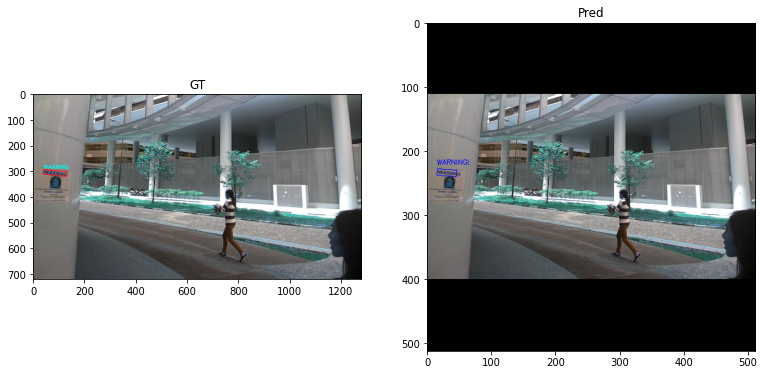

In [282]:
load_image(train_data_df['image'][40],train_data_df['cordinate'][40],train_data_df['GT'][40])

129 text boxes before nms
GT text: ['dbs']
Predicted text: ['dbs'] 

Total correct recognized words: 1
Totla incorrectly recognized words: 0 

Accuracy: 100.0 

--------------------------------------------------------------------------- 



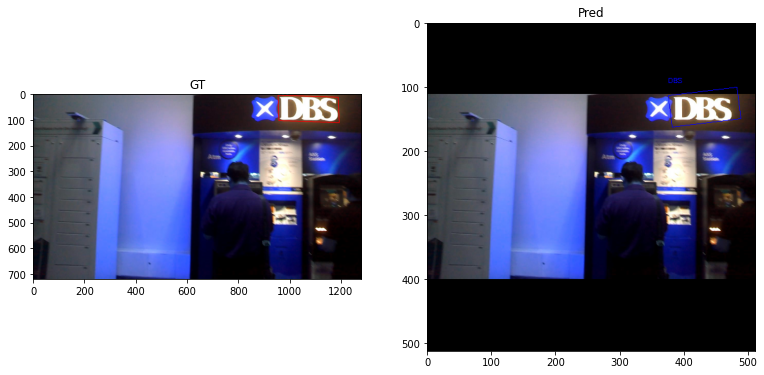

In [283]:
load_image(train_data_df['image'][77],train_data_df['cordinate'][77],train_data_df['GT'][77])

56 text boxes before nms
GT text: ['storey', 'lobby', 'lift']
Predicted text: ['t', 'lobby', 'storey'] 

Total correct recognized words: 2
Totla incorrectly recognized words: 1 

Accuracy: 66.66666666666667 

--------------------------------------------------------------------------- 



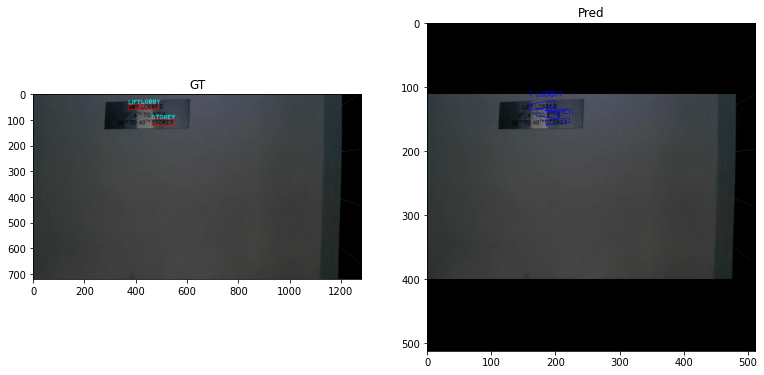

In [290]:
load_image(train_data_df['image'][68],train_data_df['cordinate'][68],train_data_df['GT'][68])

59 text boxes before nms
GT text: ['sincere']
Predicted text: ['sincere'] 

Total correct recognized words: 1
Totla incorrectly recognized words: 0 

Accuracy: 100.0 

--------------------------------------------------------------------------- 



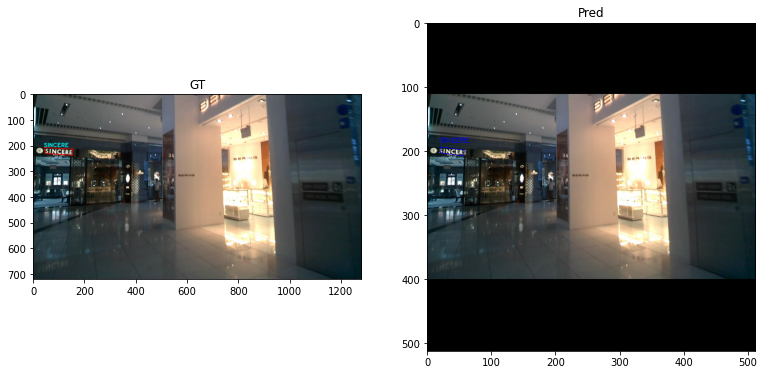

In [293]:
load_image(test_data_df['image'][24],test_data_df['cordinate'][24],test_data_df['GT'][24])

341 text boxes before nms
GT text: ['sale', 'new', 'sale', 'further', 'sale', 'lines', 'added']
Predicted text: ['sale', 'ee', 'va', 'rire', 'an', 'tad', '1nes', 'se', 'ye', 'a'] 

Total correct recognized words: 3
Totla incorrectly recognized words: 4 

Accuracy: 42.857142857142854 

--------------------------------------------------------------------------- 



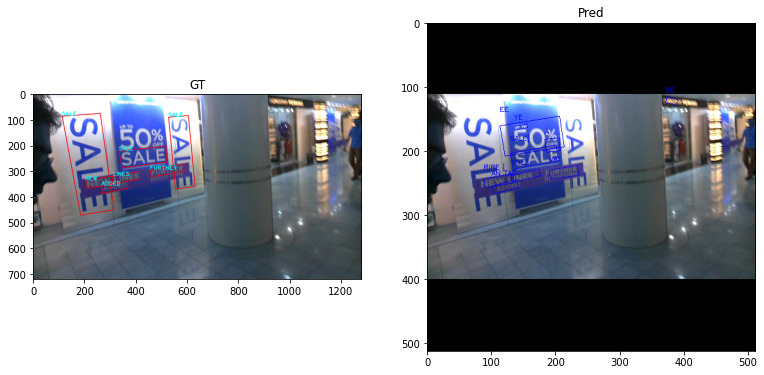

In [329]:
load_image(test_data_df['image'][72],test_data_df['cordinate'][72],test_data_df['GT'][72])

54 text boxes before nms
GT text: ['sale', 'marc']
Predicted text: ['sale'] 

Total correct recognized words: 1
Totla incorrectly recognized words: 1 

Accuracy: 50.0 

--------------------------------------------------------------------------- 



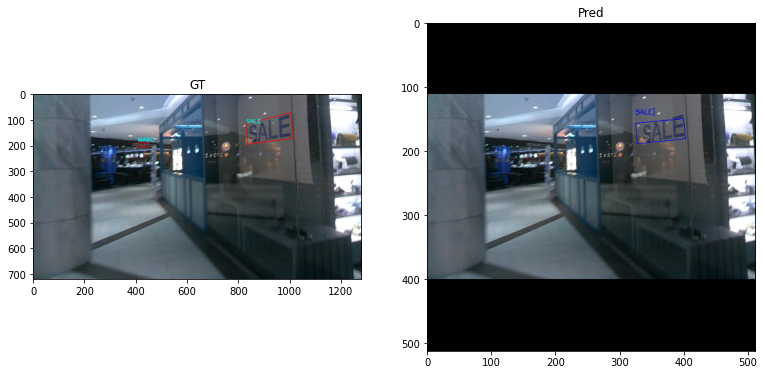

In [304]:
load_image(test_data_df['image'][3],test_data_df['cordinate'][3],test_data_df['GT'][3])